# On-Axis Field of a Solenoid Demo

This demo compares the numerically computed on-axis magnetic field of a model solenoid with the known analytical formula.

A solenoid is modeled as a series of discrete current rings. The total magnetic field is the sum of the fields from each ring. We compute the Taylor series for this field along the solenoid's axis and compare its coefficients with the coefficients from the Taylor series of the analytical formula.

In [1]:
import numpy as np
from mtflib import *
from applications.em.biot_savart import serial_biot_savart
from applications.em.current_ring import current_ring
from mtflib.taylor_function import MultivariateTaylorFunctionBase
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1. Visualize the Geometry

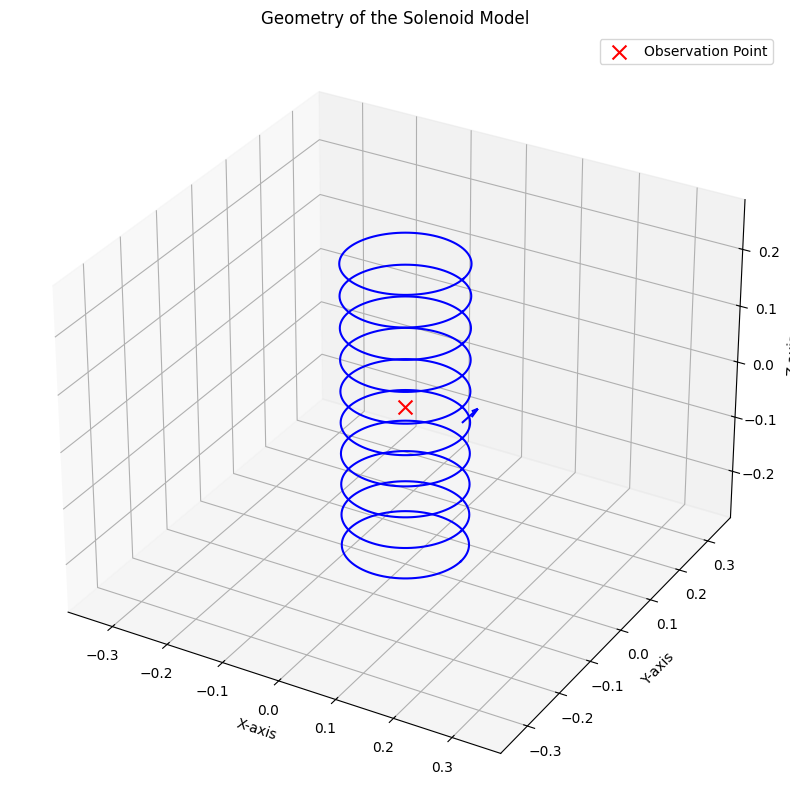

In [2]:
# --- Solenoid Parameters for visualization ---
solenoid_radius = 0.1
solenoid_length = 0.5
num_rings_vis = 10 # Just a few rings for a clear visual
observation_point = [0, 0, 0] # At the center of the solenoid

# --- Visualize the Setup ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
theta = np.linspace(0, 2 * np.pi, 100)

# Plot each ring of the solenoid
ring_positions_z_vis = np.linspace(-solenoid_length / 2, solenoid_length / 2, num_rings_vis)
for z_pos in ring_positions_z_vis:
    loop_x = solenoid_radius * np.cos(theta)
    loop_y = solenoid_radius * np.sin(theta)
    ax.plot(loop_x, loop_y, z_pos, 'b-')

# Add an arrow for current direction on the middle ring
ax.quiver(solenoid_radius, 0, 0, 0, 1, 0, length=0.05, normalize=True, color='b', arrow_length_ratio=0.4)

# Plot the observation point
ax.scatter(observation_point[0], observation_point[1], observation_point[2], c='r', marker='x', s=100, label='Observation Point')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Geometry of the Solenoid Model')
ax.legend()
ax.axis('equal')
plt.show()

### 2. Numerical B-Field Calculation

In [3]:
# --- MTF Setup ---
initialize_mtf_globals(max_order=6, max_dimension=4)
set_global_etol(1e-12)
z = Var(3)

# --- Solenoid Parameters ---
solenoid_radius = 0.1
solenoid_length = 0.5
num_rings = 50
current = 1.0
turns_per_meter = num_rings / solenoid_length

# --- Field Point on the axis ---
field_point_mtf = np.array([[0, 0, z]], dtype=object)

# --- Calculate B-field by summing contributions from each ring ---
total_B_numerical = np.array([MultivariateTaylorFunctionBase.from_constant(0.0) for _ in range(3)], dtype=object)
ring_positions_z = np.linspace(-solenoid_length / 2, solenoid_length / 2, num_rings)
for z_pos in ring_positions_z:
    segment_mtfs, element_lengths, direction_vectors = current_ring(
        solenoid_radius, 20, np.array([0, 0, z_pos]), np.array([0, 0, 1]))
    B_ring_with_u = serial_biot_savart(segment_mtfs, element_lengths, direction_vectors, field_point_mtf)
    B_ring = [integrate(bfld, 4, -1, 1) for bfld in B_ring_with_u[0]]
    total_B_numerical += B_ring

B_z_numerical = total_B_numerical[2]
print("Computed Bz from Solenoid Model (Taylor Series Coefficients):")
print(B_z_numerical.get_tabular_dataframe())

Initializing MTF globals with: _GLOBAL_MAX_ORDER=6, _GLOBAL_MAX_DIMENSION=4
Loading/Precomputing Taylor coefficients up to order 6
Global precomputed coefficients loading/generation complete.
Size of precomputed_coefficients dictionary in memory: 464 bytes, 0.45 KB, 0.00 MB
MTF globals initialized: _GLOBAL_MAX_ORDER=6, _GLOBAL_MAX_DIMENSION=4, _INITIALIZED=True
Max coefficient count (order=6, nvars=4): 210
Precomputed coefficients loaded and ready for use.


Computed Bz from Solenoid Model (Taylor Series Coefficients):
          Coefficient  Order     Exponents
0  1.146585093572e-04      0  (0, 0, 0, 0)
1 -3.048515550090e-04      2  (0, 0, 2, 0)
2 -5.186877004166e-03      4  (0, 0, 4, 0)
3 -5.974433015188e-02      6  (0, 0, 6, 0)


### 3. Implement the Analytical Formula

In [4]:
mu_0 = 4 * math.pi * 1e-7
z1 = -solenoid_length / 2
z2 = solenoid_length / 2
cos_theta_1 = (z - z1) / sqrt_taylor((z - z1)**2 + solenoid_radius**2)
cos_theta_2 = (z - z2) / sqrt_taylor((z - z2)**2 + solenoid_radius**2)
B_z_analytical = (mu_0 * turns_per_meter * current / 2) * (cos_theta_1 - cos_theta_2)
print("Analytical Bz for Solenoid (Taylor Series Coefficients):")
print(B_z_analytical.get_tabular_dataframe())

Analytical Bz for Solenoid (Taylor Series Coefficients):
          Coefficient  Order     Exponents
0  1.166758220446e-04      0  (0, 0, 0, 0)
1 -3.329631069049e-04      2  (0, 0, 2, 0)
2 -5.806728776779e-03      4  (0, 0, 4, 0)
3 -6.766461594820e-02      6  (0, 0, 6, 0)


### 4. Compare the Results

In [5]:
print("--- Comparison of Taylor Series Coefficients (Bz component) ---")
df_num = B_z_numerical.get_tabular_dataframe().rename(columns={'Coefficient': 'Numerical'})
df_an = B_z_analytical.get_tabular_dataframe().rename(columns={'Coefficient': 'Analytical'})
comparison = pd.merge(df_num, df_an, on=['Order', 'Exponents'], how='outer').fillna(0)
comparison['RelativeError'] = np.abs(comparison['Numerical'] - comparison['Analytical']) / np.abs(comparison['Analytical'])
comparison['RelativeError'] = comparison['RelativeError'].replace([np.inf, -np.inf], 0).fillna(0)
print(comparison[['Exponents', 'Order', 'Numerical', 'Analytical', 'RelativeError']])

--- Comparison of Taylor Series Coefficients (Bz component) ---
      Exponents  Order           Numerical          Analytical      RelativeError
0  (0, 0, 0, 0)      0  1.146585093572e-04  1.166758220446e-04 1.728989478714e-02
1  (0, 0, 2, 0)      2 -3.048515550090e-04 -3.329631069049e-04 8.442842859441e-02
2  (0, 0, 4, 0)      4 -5.186877004166e-03 -5.806728776779e-03 1.067471542828e-01
3  (0, 0, 6, 0)      6 -5.974433015188e-02 -6.766461594820e-02 1.170521059690e-01
